In [1]:
%matplotlib inline
from common import *
from matplotlib import pyplot as plt
import smart_open

In [2]:
import xml.etree.ElementTree as ET

tree = ET.parse('../data/TestDocumentsResult.xml')
root = tree.getroot()

In [3]:
gold = {}
for child in root:
    sims = []
    for similars in child:
        for sim in similars:
            sims.append(sim.attrib['docId'])
    gold[child.attrib['docId']] = sims

In [4]:
import ujson

def iter_docs():
    with GzipFile('../data/lingvo/corpus_json.txt.gz', 'r') as fr:
        for line in fr:
            _id, sents = ujson.loads(line)
            yield _id, sents
                
class Documents():
    def __iter__(self):
        for _id, doc in iter_docs():
            unlisted = [w for s in doc for w in s]
            yield gensim.models.doc2vec.TaggedDocument(unlisted, [_id])

In [5]:
s = u"к1-_г/м. 3-3"
prog = re.compile("[\W\d]", re.UNICODE)
print(prog.sub('', s))

к_гм


In [5]:
# model = Doc2Vec(size=200, window=15, min_count=5, dm=0, workers=cpu_count, iter=1,
#                sample=1e-4, alpha=.01, min_alpha=.0001) # dbow_words=1

In [6]:
model = Doc2Vec(Documents(), size=200,window=8,min_count=5,dm=1,workers=cpu_count,iter=10)

2017-10-21 03:35:26,159 [MainThread  ] [INFO ]  collecting all words and their counts
2017-10-21 03:35:26,167 [MainThread  ] [INFO ]  PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-10-21 03:35:36,137 [MainThread  ] [INFO ]  PROGRESS: at example #10000, processed 7516342 words (753995/s), 178997 word types, 10000 tags
2017-10-21 03:35:45,979 [MainThread  ] [INFO ]  PROGRESS: at example #20000, processed 15216095 words (782404/s), 291883 word types, 20000 tags
2017-10-21 03:35:55,653 [MainThread  ] [INFO ]  PROGRESS: at example #30000, processed 22780196 words (781972/s), 389575 word types, 30000 tags
2017-10-21 03:36:05,530 [MainThread  ] [INFO ]  PROGRESS: at example #40000, processed 30663046 words (798178/s), 481411 word types, 40000 tags
2017-10-21 03:36:15,322 [MainThread  ] [INFO ]  PROGRESS: at example #50000, processed 38375315 words (787660/s), 563560 word types, 50000 tags
2017-10-21 03:36:24,793 [MainThread  ] [INFO ]  PROGRESS: at example #60000,

KeyboardInterrupt: 

In [ ]:
model.save("../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10")

In [5]:
model = Doc2Vec.load("../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10")

2017-10-21 02:32:17,322 [MainThread  ] [INFO ]  loading Doc2Vec object from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10
2017-10-21 02:32:26,022 [MainThread  ] [INFO ]  loading docvecs recursively from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.docvecs.* with mmap=None
2017-10-21 02:32:26,023 [MainThread  ] [INFO ]  loading doctag_syn0 from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.docvecs.doctag_syn0.npy with mmap=None
2017-10-21 02:32:26,203 [MainThread  ] [INFO ]  loading wv recursively from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.wv.* with mmap=None
2017-10-21 02:32:26,204 [MainThread  ] [INFO ]  loading syn0 from ../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10.wv.syn0.npy with mmap=None
2017-10-21 02:32:26,427 [MainThread  ] [INFO ]  setting ignored attribute syn0norm to None
2017-10-21 02:32:26,427 [MainThread  ] [INFO ]  loading syn1neg from ../data/lingvo/d2v_size=200,window=8,min_count=

In [6]:
most = model.most_similar(u'стол')
for w, score in most:
    print(w + ' %s' % score)

2017-10-21 02:23:56,200 [MainThread  ] [INFO ]  precomputing L2-norms of word weight vectors


столик 0.789712607861
подставка 0.666086912155
платформа 0.6361079216
приспособление 0.611008882523
лоток 0.596067488194
рама 0.567093968391
держатель 0.563387930393
инструмент 0.558503806591
столешница 0.5546194911
поддон 0.554516196251


In [6]:
preds = {}
for k in gold.keys():
    sims = model.docvecs.most_similar(positive=[k], topn=200)
    preds[k] = [i for i,score in sims]

2017-10-21 02:32:29,778 [MainThread  ] [INFO ]  precomputing L2-norms of doc weight vectors


100%|██████████| 184/184 [00:00<00:00, 44221.40it/s]
2017-10-21 02:32:44,213 [MainThread  ] [INFO ]  
acc10     0.111511
acc20     0.129496
acc200    0.197842
dtype: float64


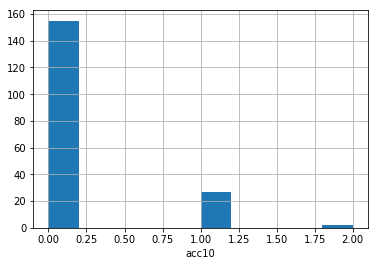

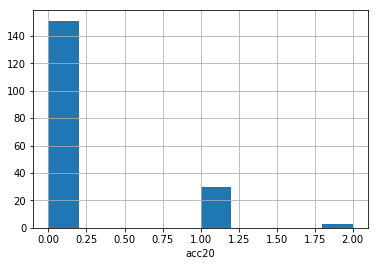

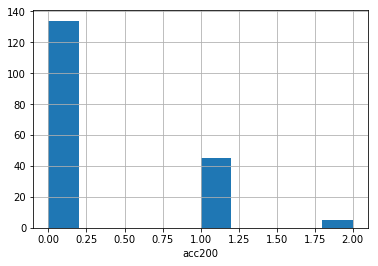

In [7]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

# Use MPK rules

In [5]:
fields = ['section', 'class_']

In [6]:
rules = np.load('../data/rules_%s.npy' % '_'.join(fields))
with open('../data/%s_index.pkl' % '_'.join(fields), 'rb') as f:
    columns, index = pickle.load(f)

In [7]:
df = pd.DataFrame(rules, index = index, columns=columns)

In [44]:
preds = {}
for k, doc in tqdm_notebook(test_docs.items()):
    inferred_vector = model.infer_vector(doc, steps=5)
    sims = model.docvecs.most_similar([inferred_vector], topn=model.docvecs.count)
    if k in df:
        valid = df.index[df[k]]
        preds[k] = [_id for _id,score in sims if _id in valid][:201]
    else:
        preds[k] = [_id for _id,score in sims[:201]]    

100%|██████████| 184/184 [00:00<00:00, 22843.03it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.289855
acc20     0.344203
acc200    0.495652
dtype: float64


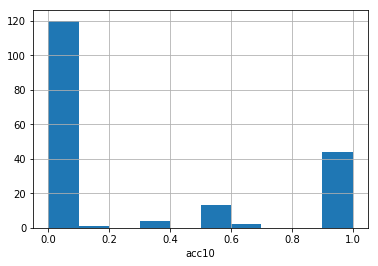

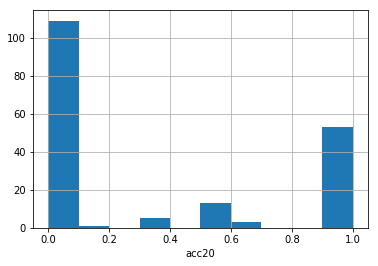

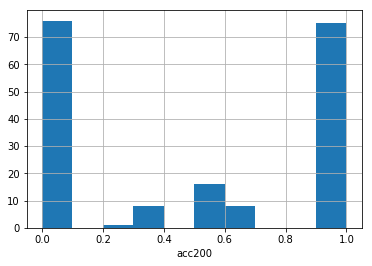

In [45]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [47]:
# section', 'class_
# acc10     0.279891
# acc20     0.316123
# acc200    0.483152

# section
# acc10     0.289855
# acc20     0.344203
# acc200    0.495652

In [ ]:
test_ids = set(gold.keys() + [vi for v in gold.values() for vi in v])

In [ ]:
folder = join(DATA_FOLDER, 'documents/')

test_docs = {}
fnames = glob(join(folder, '*.json.gz'))
for k,doc in iter_docs(fnames):
    if k in test_ids:
        unlisted = [w for s in doc for w in s]
        test_docs[k] = unlisted

2017-10-07 10:52:19,146 [MainThread  ] [INFO ]  0: ../data/documents/72.json.gz
2017-10-07 10:52:19,237 [MainThread  ] [INFO ]  1: ../data/documents/228.json.gz
2017-10-07 10:52:20,138 [MainThread  ] [INFO ]  2: ../data/documents/791.json.gz
2017-10-07 10:52:20,432 [MainThread  ] [INFO ]  3: ../data/documents/369.json.gz
2017-10-07 10:52:21,729 [MainThread  ] [INFO ]  4: ../data/documents/19.json.gz
2017-10-07 10:52:22,565 [MainThread  ] [INFO ]  5: ../data/documents/483.json.gz
2017-10-07 10:52:22,962 [MainThread  ] [INFO ]  6: ../data/documents/165.json.gz
2017-10-07 10:52:23,085 [MainThread  ] [INFO ]  7: ../data/documents/233.json.gz
2017-10-07 10:52:23,163 [MainThread  ] [INFO ]  8: ../data/documents/299.json.gz
2017-10-07 10:52:23,322 [MainThread  ] [INFO ]  9: ../data/documents/482.json.gz
2017-10-07 10:52:23,495 [MainThread  ] [INFO ]  10: ../data/documents/473.json.gz
2017-10-07 10:52:25,047 [MainThread  ] [INFO ]  11: ../data/documents/117.json.gz
2017-10-07 10:52:25,239 [Mai

2017-10-07 10:55:12,330 [MainThread  ] [INFO ]  101: ../data/documents/535.json.gz
2017-10-07 10:55:13,495 [MainThread  ] [INFO ]  102: ../data/documents/328.json.gz
2017-10-07 10:55:16,879 [MainThread  ] [INFO ]  103: ../data/documents/900.json.gz
2017-10-07 10:55:17,676 [MainThread  ] [INFO ]  104: ../data/documents/656.json.gz
2017-10-07 10:55:23,949 [MainThread  ] [INFO ]  105: ../data/documents/666.json.gz
2017-10-07 10:55:27,023 [MainThread  ] [INFO ]  106: ../data/documents/954.json.gz
2017-10-07 10:55:27,984 [MainThread  ] [INFO ]  107: ../data/documents/860.json.gz
2017-10-07 10:55:30,468 [MainThread  ] [INFO ]  108: ../data/documents/908.json.gz
2017-10-07 10:55:38,063 [MainThread  ] [INFO ]  110: ../data/documents/437.json.gz
2017-10-07 10:55:38,999 [MainThread  ] [INFO ]  111: ../data/documents/962.json.gz
2017-10-07 10:55:39,641 [MainThread  ] [INFO ]  112: ../data/documents/46.json.gz
2017-10-07 10:55:41,585 [MainThread  ] [INFO ]  113: ../data/documents/409.json.gz
2017-

2017-10-07 10:58:20,338 [MainThread  ] [INFO ]  201: ../data/documents/828.json.gz
2017-10-07 10:58:23,035 [MainThread  ] [INFO ]  202: ../data/documents/649.json.gz
2017-10-07 10:58:26,438 [MainThread  ] [INFO ]  203: ../data/documents/603.json.gz
2017-10-07 10:58:29,292 [MainThread  ] [INFO ]  204: ../data/documents/255.json.gz
2017-10-07 10:58:31,272 [MainThread  ] [INFO ]  205: ../data/documents/700.json.gz
2017-10-07 10:58:31,688 [MainThread  ] [INFO ]  206: ../data/documents/471.json.gz
2017-10-07 10:58:32,659 [MainThread  ] [INFO ]  207: ../data/documents/798.json.gz
2017-10-07 10:58:33,247 [MainThread  ] [INFO ]  208: ../data/documents/394.json.gz
2017-10-07 10:58:33,484 [MainThread  ] [INFO ]  209: ../data/documents/58.json.gz
2017-10-07 10:58:34,407 [MainThread  ] [INFO ]  210: ../data/documents/948.json.gz
2017-10-07 10:58:35,416 [MainThread  ] [INFO ]  211: ../data/documents/140.json.gz
2017-10-07 10:58:36,585 [MainThread  ] [INFO ]  212: ../data/documents/493.json.gz
2017-

2017-10-07 11:01:54,748 [MainThread  ] [INFO ]  300: ../data/documents/178.json.gz
2017-10-07 11:01:56,379 [MainThread  ] [INFO ]  301: ../data/documents/819.json.gz
2017-10-07 11:02:04,730 [MainThread  ] [INFO ]  302: ../data/documents/380.json.gz
2017-10-07 11:02:08,261 [MainThread  ] [INFO ]  303: ../data/documents/363.json.gz
2017-10-07 11:02:09,613 [MainThread  ] [INFO ]  304: ../data/documents/848.json.gz
2017-10-07 11:02:10,118 [MainThread  ] [INFO ]  305: ../data/documents/524.json.gz
2017-10-07 11:02:10,713 [MainThread  ] [INFO ]  306: ../data/documents/379.json.gz
2017-10-07 11:02:14,911 [MainThread  ] [INFO ]  307: ../data/documents/895.json.gz
2017-10-07 11:02:17,421 [MainThread  ] [INFO ]  308: ../data/documents/557.json.gz
2017-10-07 11:02:23,140 [MainThread  ] [INFO ]  309: ../data/documents/338.json.gz
2017-10-07 11:02:24,190 [MainThread  ] [INFO ]  310: ../data/documents/176.json.gz
2017-10-07 11:02:25,254 [MainThread  ] [INFO ]  311: ../data/documents/794.json.gz
2017

2017-10-07 11:05:13,793 [MainThread  ] [INFO ]  399: ../data/documents/345.json.gz
2017-10-07 11:05:14,187 [MainThread  ] [INFO ]  400: ../data/documents/319.json.gz
2017-10-07 11:05:15,938 [MainThread  ] [INFO ]  401: ../data/documents/66.json.gz
2017-10-07 11:05:16,369 [MainThread  ] [INFO ]  402: ../data/documents/674.json.gz
2017-10-07 11:05:18,977 [MainThread  ] [INFO ]  403: ../data/documents/244.json.gz
2017-10-07 11:05:22,505 [MainThread  ] [INFO ]  404: ../data/documents/767.json.gz
2017-10-07 11:05:23,992 [MainThread  ] [INFO ]  405: ../data/documents/205.json.gz
2017-10-07 11:05:24,448 [MainThread  ] [INFO ]  406: ../data/documents/277.json.gz
2017-10-07 11:05:27,132 [MainThread  ] [INFO ]  407: ../data/documents/642.json.gz
2017-10-07 11:05:29,081 [MainThread  ] [INFO ]  408: ../data/documents/400.json.gz
2017-10-07 11:05:29,756 [MainThread  ] [INFO ]  409: ../data/documents/521.json.gz
2017-10-07 11:05:30,898 [MainThread  ] [INFO ]  410: ../data/documents/737.json.gz
2017-

2017-10-07 11:08:13,435 [MainThread  ] [INFO ]  498: ../data/documents/496.json.gz
2017-10-07 11:08:14,614 [MainThread  ] [INFO ]  499: ../data/documents/170.json.gz
2017-10-07 11:08:14,805 [MainThread  ] [INFO ]  500: ../data/documents/159.json.gz
2017-10-07 11:08:15,459 [MainThread  ] [INFO ]  501: ../data/documents/902.json.gz
2017-10-07 11:08:15,756 [MainThread  ] [INFO ]  502: ../data/documents/762.json.gz
2017-10-07 11:08:16,010 [MainThread  ] [INFO ]  503: ../data/documents/668.json.gz
2017-10-07 11:08:17,503 [MainThread  ] [INFO ]  504: ../data/documents/404.json.gz
2017-10-07 11:08:17,904 [MainThread  ] [INFO ]  505: ../data/documents/939.json.gz
2017-10-07 11:08:23,908 [MainThread  ] [INFO ]  506: ../data/documents/411.json.gz
2017-10-07 11:08:27,292 [MainThread  ] [INFO ]  507: ../data/documents/658.json.gz
2017-10-07 11:08:34,224 [MainThread  ] [INFO ]  508: ../data/documents/924.json.gz
2017-10-07 11:08:39,455 [MainThread  ] [INFO ]  509: ../data/documents/247.json.gz
2017

2017-10-07 11:11:45,144 [MainThread  ] [INFO ]  597: ../data/documents/904.json.gz
2017-10-07 11:11:45,765 [MainThread  ] [INFO ]  598: ../data/documents/622.json.gz
2017-10-07 11:11:47,825 [MainThread  ] [INFO ]  599: ../data/documents/640.json.gz
2017-10-07 11:11:48,608 [MainThread  ] [INFO ]  600: ../data/documents/919.json.gz
2017-10-07 11:11:55,584 [MainThread  ] [INFO ]  601: ../data/documents/914.json.gz
2017-10-07 11:11:57,882 [MainThread  ] [INFO ]  602: ../data/documents/615.json.gz
2017-10-07 11:12:00,880 [MainThread  ] [INFO ]  603: ../data/documents/73.json.gz
2017-10-07 11:12:01,300 [MainThread  ] [INFO ]  604: ../data/documents/772.json.gz
2017-10-07 11:12:03,553 [MainThread  ] [INFO ]  605: ../data/documents/235.json.gz
2017-10-07 11:12:03,953 [MainThread  ] [INFO ]  606: ../data/documents/621.json.gz
2017-10-07 11:12:05,031 [MainThread  ] [INFO ]  607: ../data/documents/683.json.gz
2017-10-07 11:12:08,616 [MainThread  ] [INFO ]  608: ../data/documents/273.json.gz
2017-

2017-10-07 11:14:57,922 [MainThread  ] [INFO ]  696: ../data/documents/500.json.gz
2017-10-07 11:15:00,702 [MainThread  ] [INFO ]  697: ../data/documents/227.json.gz
2017-10-07 11:15:04,831 [MainThread  ] [INFO ]  698: ../data/documents/514.json.gz
2017-10-07 11:15:07,636 [MainThread  ] [INFO ]  699: ../data/documents/555.json.gz
2017-10-07 11:15:13,869 [MainThread  ] [INFO ]  700: ../data/documents/158.json.gz
2017-10-07 11:15:15,542 [MainThread  ] [INFO ]  701: ../data/documents/436.json.gz
2017-10-07 11:15:15,837 [MainThread  ] [INFO ]  702: ../data/documents/462.json.gz
2017-10-07 11:15:17,419 [MainThread  ] [INFO ]  703: ../data/documents/911.json.gz
2017-10-07 11:15:17,974 [MainThread  ] [INFO ]  704: ../data/documents/378.json.gz
2017-10-07 11:15:20,064 [MainThread  ] [INFO ]  705: ../data/documents/812.json.gz
2017-10-07 11:15:22,420 [MainThread  ] [INFO ]  706: ../data/documents/218.json.gz
2017-10-07 11:15:23,667 [MainThread  ] [INFO ]  707: ../data/documents/508.json.gz
2017

2017-10-07 11:18:13,954 [MainThread  ] [INFO ]  795: ../data/documents/415.json.gz
2017-10-07 11:18:16,840 [MainThread  ] [INFO ]  796: ../data/documents/238.json.gz
2017-10-07 11:18:18,030 [MainThread  ] [INFO ]  797: ../data/documents/8.json.gz
2017-10-07 11:18:19,474 [MainThread  ] [INFO ]  798: ../data/documents/832.json.gz
2017-10-07 11:18:22,047 [MainThread  ] [INFO ]  799: ../data/documents/313.json.gz
2017-10-07 11:18:25,963 [MainThread  ] [INFO ]  800: ../data/documents/596.json.gz
2017-10-07 11:18:27,538 [MainThread  ] [INFO ]  801: ../data/documents/318.json.gz
2017-10-07 11:18:28,394 [MainThread  ] [INFO ]  802: ../data/documents/625.json.gz
2017-10-07 11:18:28,867 [MainThread  ] [INFO ]  803: ../data/documents/804.json.gz
2017-10-07 11:18:30,361 [MainThread  ] [INFO ]  804: ../data/documents/124.json.gz
2017-10-07 11:18:30,590 [MainThread  ] [INFO ]  805: ../data/documents/879.json.gz
2017-10-07 11:18:34,113 [MainThread  ] [INFO ]  806: ../data/documents/455.json.gz
2017-1

2017-10-07 11:22:08,408 [MainThread  ] [INFO ]  894: ../data/documents/580.json.gz
2017-10-07 11:22:09,695 [MainThread  ] [INFO ]  895: ../data/documents/48.json.gz
2017-10-07 11:22:11,129 [MainThread  ] [INFO ]  896: ../data/documents/826.json.gz
2017-10-07 11:22:13,565 [MainThread  ] [INFO ]  897: ../data/documents/513.json.gz
2017-10-07 11:22:16,620 [MainThread  ] [INFO ]  898: ../data/documents/544.json.gz
2017-10-07 11:22:19,648 [MainThread  ] [INFO ]  899: ../data/documents/286.json.gz
2017-10-07 11:22:22,180 [MainThread  ] [INFO ]  900: ../data/documents/581.json.gz
2017-10-07 11:22:22,960 [MainThread  ] [INFO ]  901: ../data/documents/183.json.gz
2017-10-07 11:22:24,478 [MainThread  ] [INFO ]  902: ../data/documents/639.json.gz
2017-10-07 11:22:24,842 [MainThread  ] [INFO ]  903: ../data/documents/208.json.gz
2017-10-07 11:22:25,052 [MainThread  ] [INFO ]  904: ../data/documents/27.json.gz
2017-10-07 11:22:25,143 [MainThread  ] [INFO ]  905: ../data/documents/280.json.gz
2017-1

2017-10-07 11:25:06,600 [MainThread  ] [INFO ]  993: ../data/documents/307.json.gz
2017-10-07 11:25:08,155 [MainThread  ] [INFO ]  994: ../data/documents/171.json.gz
2017-10-07 11:25:08,412 [MainThread  ] [INFO ]  995: ../data/documents/714.json.gz
2017-10-07 11:25:08,705 [MainThread  ] [INFO ]  996: ../data/documents/377.json.gz
2017-10-07 11:25:10,655 [MainThread  ] [INFO ]  997: ../data/documents/452.json.gz
2017-10-07 11:25:10,935 [MainThread  ] [INFO ]  998: ../data/documents/587.json.gz
2017-10-07 11:25:11,648 [MainThread  ] [INFO ]  999: ../data/documents/757.json.gz
2017-10-07 11:25:12,097 [MainThread  ] [INFO ]  1000: ../data/documents/249.json.gz


In [9]:
with open('../data/test_docs.json', 'w') as f:
    json.dump(test_docs, f)

In [8]:
with open('../data/test_docs.json', 'r') as f:
    test_docs = json.load(f)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

stat = []
for k,v in tqdm_notebook(gold.items()):
    q_vector = model.infer_vector(test_docs[k], steps=5)
    ex_vecs = []
    matched = []
    for vi in v:
        doc_vec = model.infer_vector(test_docs[vi], steps=5)
        ex_vecs.append(doc_vec)
        if k in df:
            matched.append(int(df.loc[vi,k]))
        else:
            matched.append(0)
    sim_mat = cosine_similarity([q_vector], ex_vecs)
    stat += list(zip(sim_mat[0], matched))
#     if np.max(sim_mat)>0.8:
#         break

In [12]:
df1 = pd.DataFrame(stat, columns=['cos', 'matched'])

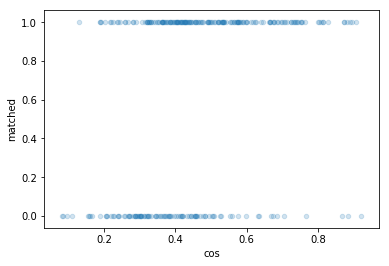

In [13]:
#section, class
df1.plot(kind='scatter', x='cos', y='matched', alpha=0.2)
plt.show()

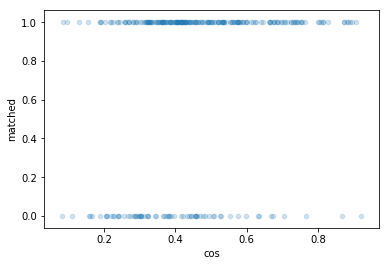

In [12]:
#section
df1.plot(kind='scatter', x='cos', y='matched', alpha=0.2)
plt.show()